# Analysis of decentralised iterative auction heuristics

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from src.extra.io import save_plot, ImageFormat

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

## Heuristic grid search

In [2]:
results_filename = '../data/old/dia_heuristics/dia_heuristic_grid_search_paper_r_t30_s6_dt07-22_12-17-27.json'

with open(results_filename) as file:
    results_data = json.load(file)

In [3]:
heuristic_results = {}
for model_results in results_data:
    for heuristic, heuristic_result in model_results.items():
        if heuristic == 'model':
            continue
        if heuristic in heuristic_results:
            heuristic_results[heuristic].append(heuristic_result)
        else:
            heuristic_results[heuristic] = [heuristic_result]
            
print(f'Number of heuristics: {len(heuristic_results)}')

Number of heuristics: 25


In [4]:
heuristic_avg_results = []
for heuristic, results in heuristic_results.items():
    heuristic_avg_results.append([
        heuristic,
        results[0]['price change'],
        results[0]['initial price'],
        [r['social welfare'] for r in results],
        [r['social welfare percent'] for r in results],
        [r['percentage tasks allocated'] for r in results],
        [r['total revenue'] for r in results],
        [r['rounds'] for r in results],
        [r['solve time'] for r in results],
        [task_price for r in results for task_price in r['task prices'].values()],
        np.mean([r['social welfare'] for r in results]),
        np.mean([r['total revenue'] for r in results]),
        np.mean([r['rounds'] for r in results]),
        np.mean([task_rounds for r in results for task_rounds in r['task rounds'].values()])
    ])
    
heuristic_df = pd.DataFrame(heuristic_avg_results, columns=[
    'name', 'price change', 'initial price', 'social welfare', 'social welfare percent', 
    'percentage tasks allocated', 'revenue', 'rounds', 'solve time', 'task prices', 
    'avg social welfare', 'avg revenue', 'avg rounds', 'avg task rounds',
])
heuristic_df = heuristic_df.sort_values(by=['price change', 'initial price'])

In [36]:
def no_colourbar(ax, df, col, title='', initial_prices=['40', '35', '30', '25', '20'], price_changes=['1', '3', '5', '7', '10']):
    ax.set_yticks(np.arange(len(price_changes)))
    ax.set_yticklabels(list(reversed(price_changes)), fontsize=11)
    ax.set_ylabel('Bid Increment', fontsize=13)
    
    ax.set_xticks(np.arange(len(initial_prices)))
    ax.set_xticklabels(list(reversed(initial_prices)), fontsize=11)
    ax.set_xlabel('Reserve Price', fontsize=13)
    
    heatmap = ax.imshow(df.pivot(index='price change', columns='initial price', values=col).sort_index(axis=0, ascending=False))
    
    ax.set_title(title, fontsize=14)
    mean_col = heuristic_df[col].mean()
    for x, initial_price in enumerate(initial_prices):
        for y, price_change in enumerate(price_changes):
            label = df[df['name'] == f'IP: {initial_price}, PC: {price_change}'].get(col).values[0]
            label_colour = 'white' if int(label) < mean_col else 'black'
            ax.text(len(initial_prices) - 1 - x, len(price_changes) - 1 - y, 
                    round(label), color=label_colour, ha='center', va='center', weight='bold', fontsize=12)

Save file location: figs/eps/dia_heuristics_grid_search.eps
Save file location: figs/png/dia_heuristics_grid_search.png
Save file location: figs/pdf/dia_heuristics_grid_search.pdf


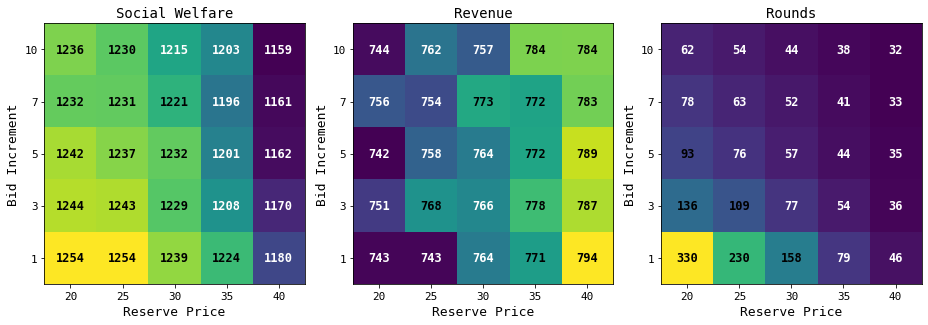

In [37]:
fig, (ax_social_welfare, ax_revenue, ax_rounds) = plt.subplots(1, 3, figsize=(13, 4.5))

no_colourbar(ax_social_welfare, heuristic_df, 'avg social welfare', 'Social Welfare')
no_colourbar(ax_revenue, heuristic_df, 'avg revenue', 'Revenue')
no_colourbar(ax_rounds, heuristic_df, 'avg rounds', 'Rounds')
plt.tight_layout()

save_plot('dia_heuristics_grid_search')

### Task Price

Text(0.5, 1.0, 'Task Price distribution')

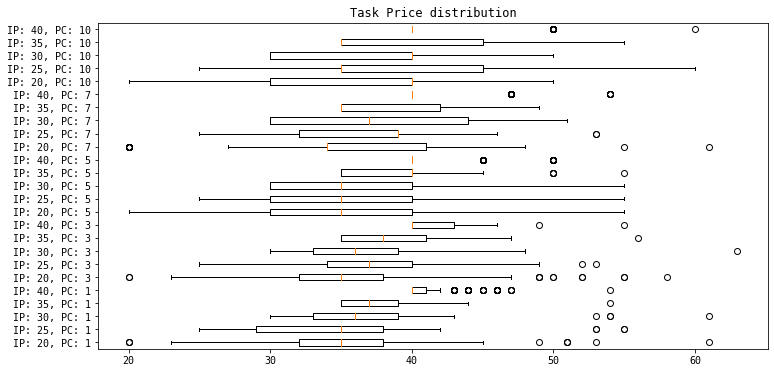

In [15]:
task_price_fig, ax_box_price = plt.subplots(figsize=(12, 6))
ax_box_price.boxplot(heuristic_df['task prices'], vert=False)
ax_box_price.set_yticklabels(heuristic_df['name'])
ax_box_price.set_title('Task Price distribution')